Here we do simulations of various processes. The first section is filled with different processes related to Brownian Motion. The second section simulates different stochastic differential equations. The third section is focused on simulations of some Levy processes. We also perform Monte-Carlo estimations of mean of some of the processes/equations

## 0. Some auxiliary stuff

In [74]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm
from typing import Callable, Optional

In [2]:
def plot_trajectories(length: float, num_splits: int, num_traj: int,  
                      y_label: str,
                      process_name: str,
                      sim_func: Callable,
                      mean_func: Optional[Callable] = None,
                      **sim_func_kwargs) -> None:
    """
    just a simple plotting function
    """
    
    plt.figure(figsize=(13, 7))
    for traj in range(num_traj):
        plt.plot(np.arange(0, length, length/(num_splits + 1)), 
                 sim_func(length, num_splits, **sim_func_kwargs))
        
        
    if mean_func is not None:
        plt.plot(np.arange(0, length, length/(num_splits + 1)), 
                 mean_func(np.arange(0, length, length/(num_splits + 1))),
                 label="true mean")
        plt.legend()
    
    plt.xlabel("$t$")
    plt.ylabel(y_label)
    plt.title(f"Simulated trajectories of a {process_name}")
    plt.xlim(0, length)
    
    plt.show()

In [3]:
def estimate_mean(length: int, num_splits: int,
                  num_iter: int, process: Callable,
                  **sim_func_kwargs) -> np.ndarray:
    
    mean_trajectory = np.zeros(num_splits+1)
    
    for i in range(num_iter):
        mean_trajectory += process(length, num_splits,
                                   **sim_func_kwargs)
        
    mean_trajectory /= num_iter
    
    return mean_trajectory

## 1. Brownian motion

### 1.1 Simple Brownian motion trajectories

In [4]:
def create_path_BM(length: float, num_splits: int) -> np.ndarray:
    """
    length: float -- last moment of time to be simulated
    num_splits: int -- number of increments to create, 
    increment is \Delta W_t and it is sample from N(0, T/N)
    
    return trajectory of brownian motion
    """
    increments = np.random.normal(loc=0, 
                                  scale=(length/num_splits) ** 0.5, 
                                  size=num_splits)
    
    trajectory = np.zeros(num_splits+1)
    trajectory[1:] = np.cumsum(increments)
    return trajectory

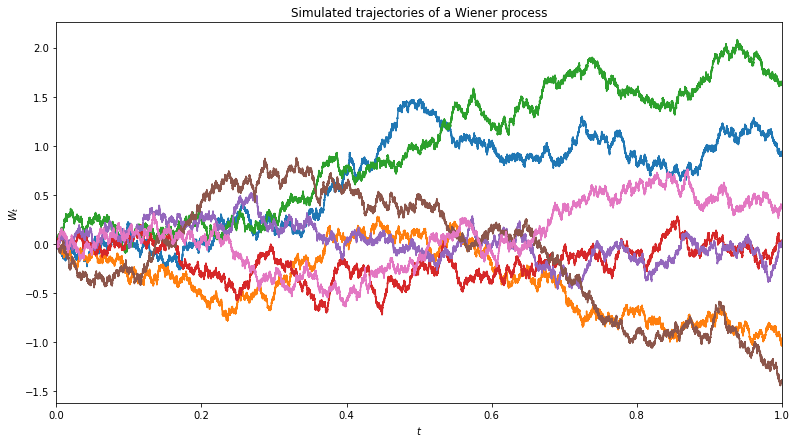

In [5]:
plot_trajectories(1, 100000, 7, "$W_t$", "Wiener process", create_path_BM)

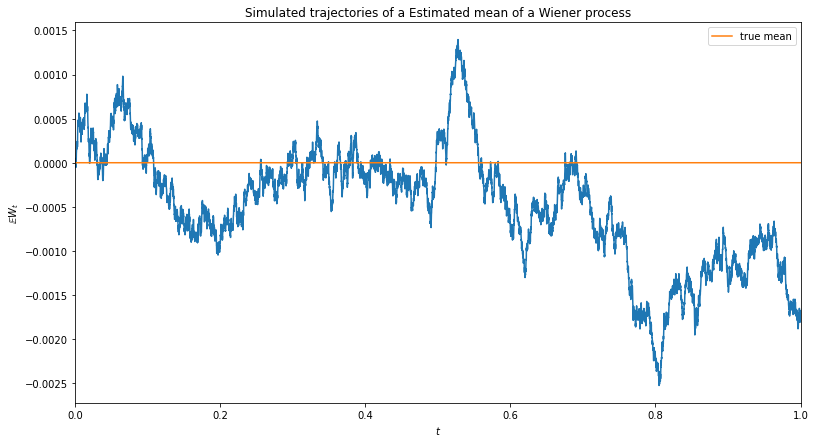

In [6]:
plot_trajectories(1, 10000, 1, "$\mathbb{E}W_t$", "Estimated mean of a Wiener process", 
                  sim_func=estimate_mean, mean_func=lambda x: np.zeros(x.shape),
                  process=create_path_BM, num_iter=100000)

### 1.2 BM with drift

In [7]:
def create_path_BM_drift(length: float, num_splits: int,
                          slope: int = 0, sd: int = 1) -> np.ndarray:
    """
    Same as simple BM trajectories but with a slope and sd parameters
    
    return a trajectrory of Brownian motion with drift
    """
    basic_BM_traj = create_path_BM(length, num_splits)
    
    linear_part = slope * np.arange(0, length, length/(num_splits + 1))
    
    trajectory = linear_part + sd * basic_BM_traj
    return trajectory

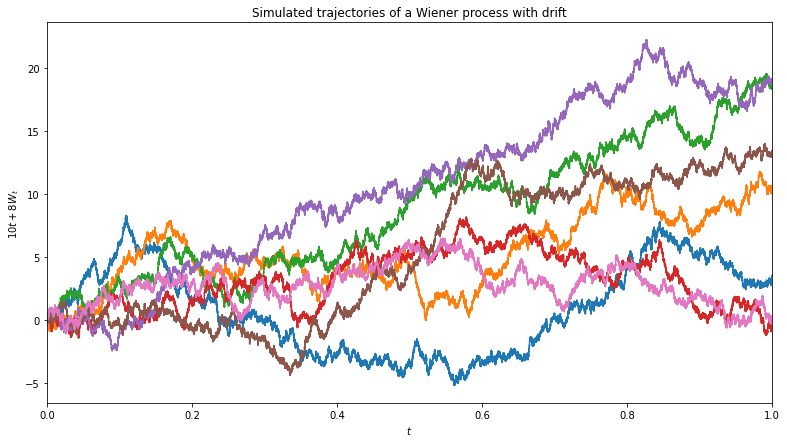

In [8]:
plot_trajectories(1, 100000, 7, f"$10t + 8 W_t$", 
                  "Wiener process with drift",
                  create_path_BM_drift, slope=10, sd=8)

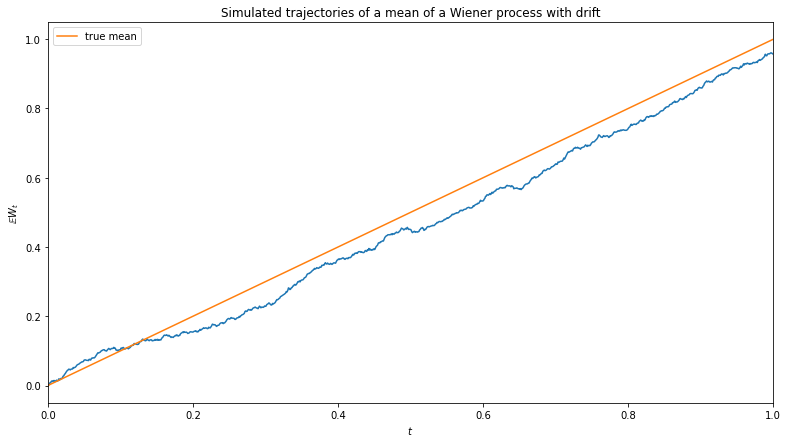

In [9]:
plot_trajectories(1, 1000, 1, "$\mathbb{E}W_t$", "mean of a Wiener process with drift", 
                  sim_func=estimate_mean, mean_func=lambda x: x,
                  process=create_path_BM_drift, num_iter=100000, slope=1, sd=20)

### 1.3 Brownian bridge

$$
B_t = W_t - \cfrac{t}{T} W_T
$$

In [10]:
def create_path_BB(length: float, num_splits: int) -> np.ndarray:
    """
    Same as create_path_BN
    
    return simulated brownian bridge
    """
    basic_BM_traj = create_path_BM(length, num_splits)
    
    linear_part = np.arange(0, length, length/(num_splits + 1))
    
    trajectory = basic_BM_traj - linear_part / length * basic_BM_traj[-1]
    return trajectory

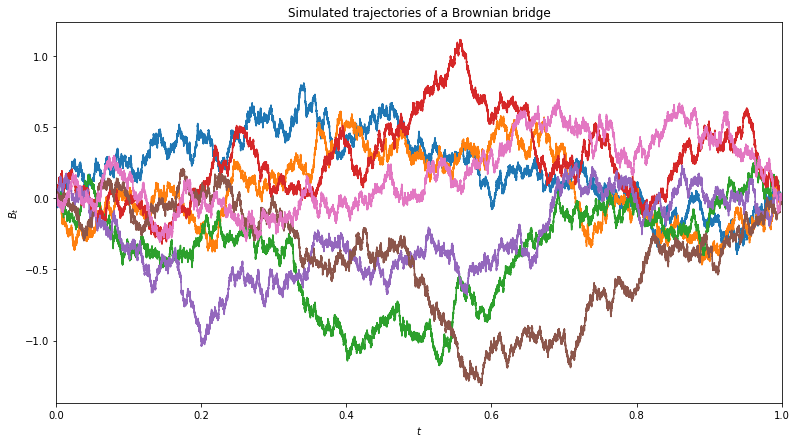

In [11]:
plot_trajectories(1, 100000, 7, 
                  "$B_t$", 
                  "Brownian bridge",
                  sim_func=create_path_BB)

### 1.4 Geometric Brownian Motion

$$
S_t = S_0 \exp((\mu - 0.5\sigma^2)t + \sigma W_t)
$$

In [12]:
def create_path_geometric_BM(length: float, num_splits: int,
                          mu: int = 0, sd: int = 1, s_0: int = 1) -> np.ndarray:
    """
    Same as simple BM trajectories but with a slope and sd parameters
    
    return a trajectrory of geometric Brownian motion 
    """
    basic_BM_traj = create_path_BM(length, num_splits)
    
    linear_part = (mu - sd/2) ** 2  * np.arange(0, length, length/(num_splits + 1))
    
    trajectory = s_0 * np.exp(linear_part + sd * basic_BM_traj)
    return trajectory

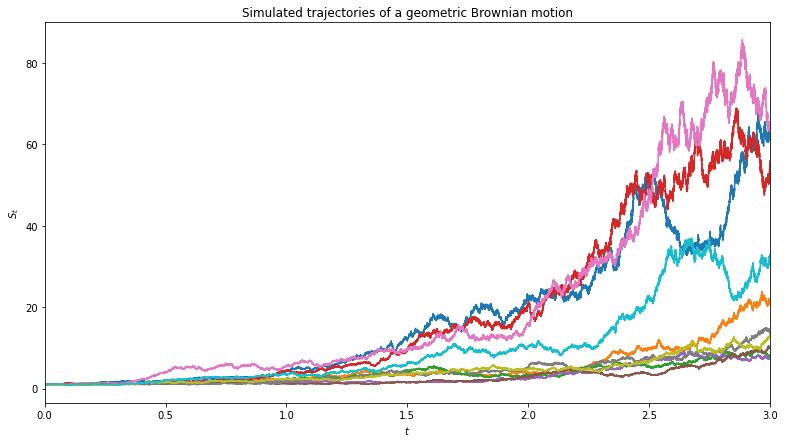

In [13]:
plot_trajectories(3, 100000, 10, 
                  "$S_t$", 
                  "geometric Brownian motion",
                  sim_func=create_path_geometric_BM, mu=1.2, sd=0.5)

## 2. SDE

The basic simulation method for stochastic differential equations of the form:
$$
dX_t = \mu(t, X_t) dt + \sigma(t, X_t) d W_t
$$
is Euler-Maruyama method. The steps to estimate such a SDE on $[0, T]$ with this method are the following:

1) Split the interval on evenly spaced sub-intervals

2) Set the desired starting value $X_0$

3) $X_{t_i} = X_{t_{i-1}} + \mu(t_{i-1}, X_{t_{i-1}}) \Delta t_i + \sigma(t_{i-1}, X_{t_{i-1}}) \Delta W_{t_i}$

4) Also we can add second-order approximation term: 
        $0.5\sigma(t_{i-1}, X_{t_{i-1}})\sigma'(t_{i-1}, X_{t_{i-1}})(\Delta W_{t_i}^2 - \Delta t_i) $ 

### 2.1 Black-Scholes equation

$$
dX_t = \mu X_t dt + \sigma X_t dW_t
$$

Applying Ito's lemma to $d(ln X_t)$ we obtain that geometric Brownian motion is a solution to this equation

In [14]:
def Black_Scholes_SDE(length: float, num_splits: int,
                     mu: int = 0, sd: int = 1, x_0: int = 1,
                     order: int = 1) -> np.ndarray:
    
    
    delta = length / num_splits
    
    increments = np.random.normal(loc=0, 
                                  scale= delta ** 0.5, 
                                  size=num_splits)
    X_t = np.zeros(num_splits + 1)
    X_t[0] = x_0
    
    for i in range(1, num_splits+1):
        X_t[i] = X_t[i-1] + mu * X_t[i-1]* delta + sd * X_t[i-1] * increments[i-1]
        
        if order == 2:
            X_t[i] += 0.5 * (sd ** 2) * X_t[i-1] * (increments[i-1] ** 2 - delta)
    
    return X_t

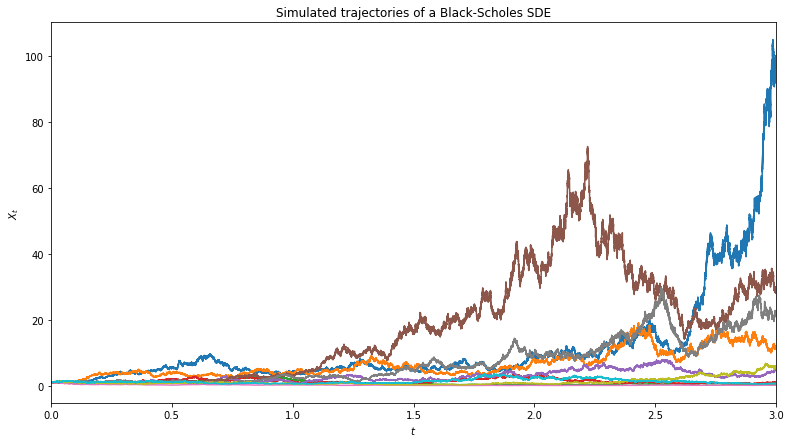

In [15]:
np.random.seed(13)

plot_trajectories(3, 100000, 10, 
                  "$X_t$", 
                  "Black-Scholes SDE",
                  sim_func=Black_Scholes_SDE, mu=1.2, sd=1)

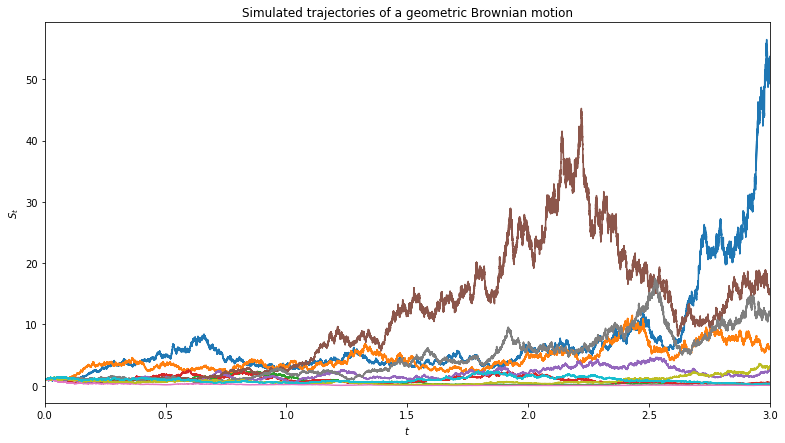

In [16]:
np.random.seed(13)
plot_trajectories(3, 100000, 10, 
                  "$S_t$", 
                  "geometric Brownian motion",
                  sim_func=create_path_geometric_BM, mu=1.2, sd=1)

As we can see both way of sampling yield equivalent results

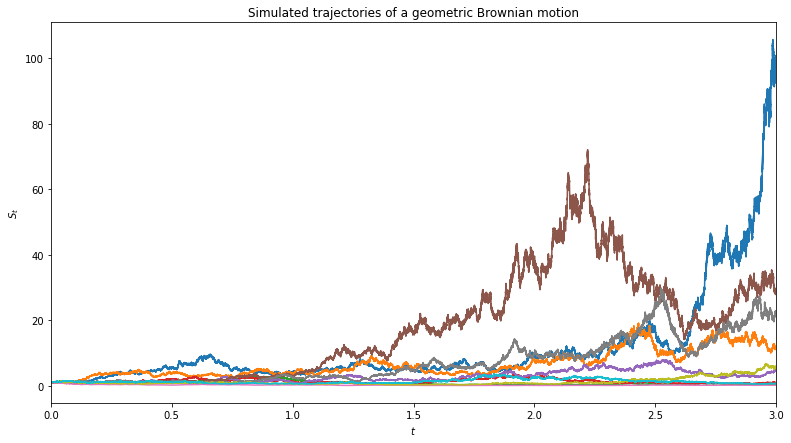

In [17]:
np.random.seed(13)
plot_trajectories(3, 100000, 10, 
                  "$S_t$", 
                  "geometric Brownian motion",
                  sim_func=Black_Scholes_SDE, 
                  mu=1.2, sd=1, order=2)

Graphically it is the same (and the errors were pretty small with such discretization). However, the order of convergence is higher here

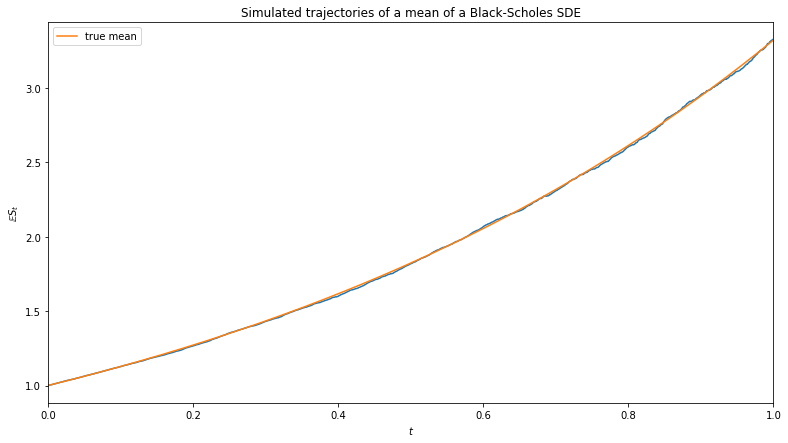

In [18]:
np.random.seed(12)

plot_trajectories(1, 1000, 1, "$\mathbb{E}S_t$", "mean of a Black-Scholes SDE", 
                  sim_func=estimate_mean, 
                  mean_func=lambda x: np.exp(1.2 * x),
                  process=Black_Scholes_SDE, num_iter=20000, mu=1.2, sd=1.5, order=2)

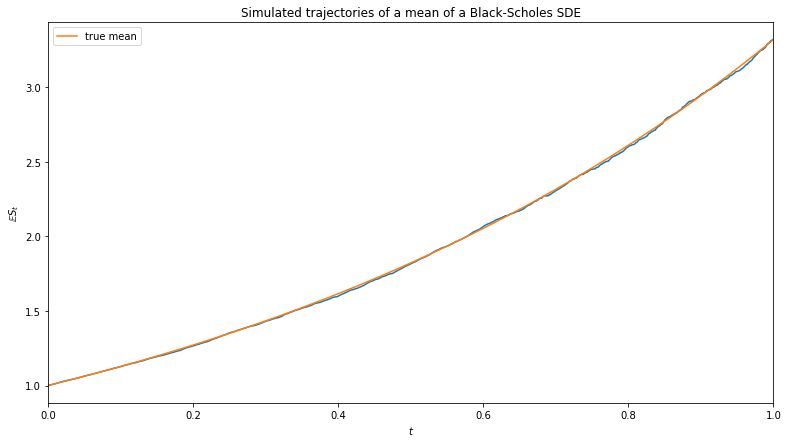

In [19]:
np.random.seed(12)

plot_trajectories(1, 1000, 1, "$\mathbb{E}S_t$", "mean of a Black-Scholes SDE", 
                  sim_func=estimate_mean, 
                  mean_func=lambda x: np.exp(1.2 * x),
                  process=Black_Scholes_SDE, num_iter=20000, mu=1.2, sd=1.5, order=1)

In [21]:
np.random.seed(12)

first_order = estimate_mean(
    length=np.exp(1),
    num_splits=1000,
    process=Black_Scholes_SDE,
    mu=1.2,
    sd=1.5,
    order=1,
    num_iter=20000
)

second_order = estimate_mean(
    length=np.exp(1),
    num_splits=1000,
    process=Black_Scholes_SDE,
    mu=1.2,
    sd=1.5,
    order=1,
    num_iter=20000
)

real_mean = np.exp(1.2 * np.linspace(0, np.exp(1), 1001))

In [22]:
print(f"First order approximation MSE: {((first_order - real_mean) ** 2).mean()}")
print(f"Second order approximation MSE: {((second_order - real_mean) ** 2).mean()}")

First order approximation MSE: 0.49170570740849434
Second order approximation MSE: 0.19405504143522304


Second order way of sampling can yield a smaller MSE!

### 2.2 Vasicek model

$$
dX_t = (a-bX_t) dt + c dW_t
$$

Here we apply Ito's lemma to $d(X_t e^{bt})$ and obtain formula
$$
X_t = e^{-bt}X_0 + \frac{a}{b}(1-e^{-bt}) + c \int_0^t e^{-b(s-t)} dW_s
$$

In [23]:
def Vasicek_SDE(length: float, num_splits: int,
                a: int = 1, b: int = 1, c: int = 1,
                x_0: int = 1) -> np.ndarray:
    
    
    delta = length / num_splits
    
    increments = np.random.normal(loc=0, 
                                  scale= delta ** 0.5, 
                                  size=num_splits)
    X_t = np.zeros(num_splits + 1)
    X_t[0] = x_0
    
    for i in range(1, num_splits+1):
        X_t[i] = X_t[i-1] + (a - b * X_t[i-1]) * delta + c * X_t[i-1] * increments[i-1]
    
    return X_t

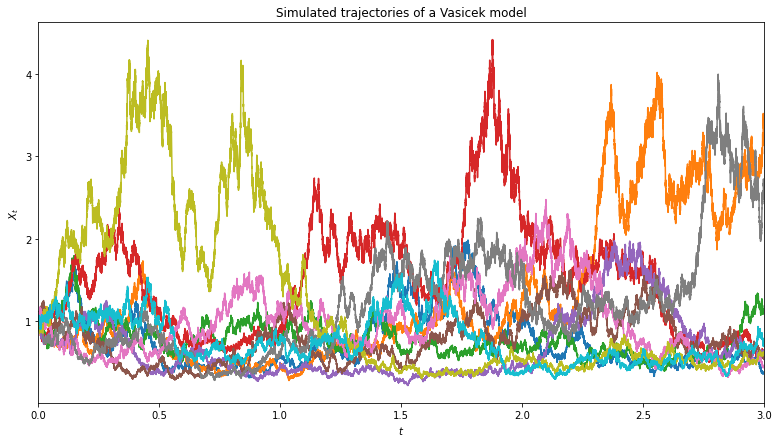

In [24]:
plot_trajectories(3, 100000, 10, 
                  "$X_t$", 
                  "Vasicek model",
                  sim_func=Vasicek_SDE)

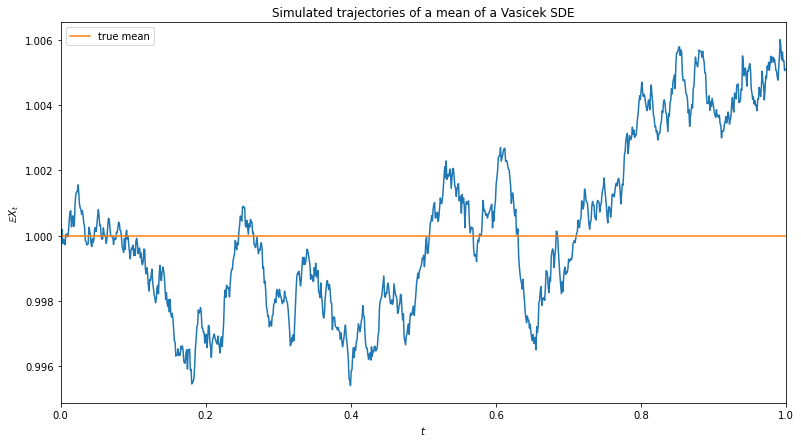

In [25]:
np.random.seed(12)

plot_trajectories(1, 1000, 1, "$\mathbb{E}X_t$", "mean of a Vasicek SDE", 
                  sim_func=estimate_mean, 
                  mean_func=lambda x: np.ones(x.shape),
                  process=Vasicek_SDE, num_iter=20000)

### 2.3 Cox-Ingersoll-Ross model

A slightly different version of Vasicek model:
$$
dX_t = (a-bX_t) dt + c \sqrt{X_t} dW_t
$$

Ito's lemma to same function yields:
$$
X_t = e^{-bt}X_0 + \frac{a}{b}(1-e^{-bt}) + c \int_0^t e^{-b(s-t)}\sqrt{X_t} dW_s
$$

In [26]:
def CIR_SDE(length: float, num_splits: int,
                a: int = 1, b: int = 1, c: int = 1,
                x_0: int = 3) -> np.ndarray:
    
    
    delta = length / num_splits
    
    increments = np.random.normal(loc=0, 
                                  scale= delta ** 0.5, 
                                  size=num_splits)
    X_t = np.zeros(num_splits + 1)
    X_t[0] = x_0
    
    for i in range(1, num_splits+1):
        X_t[i] = X_t[i-1] + (a - b * X_t[i-1]) * delta + c * (X_t[i-1] ** 0.5) * increments[i-1]
    
    return X_t

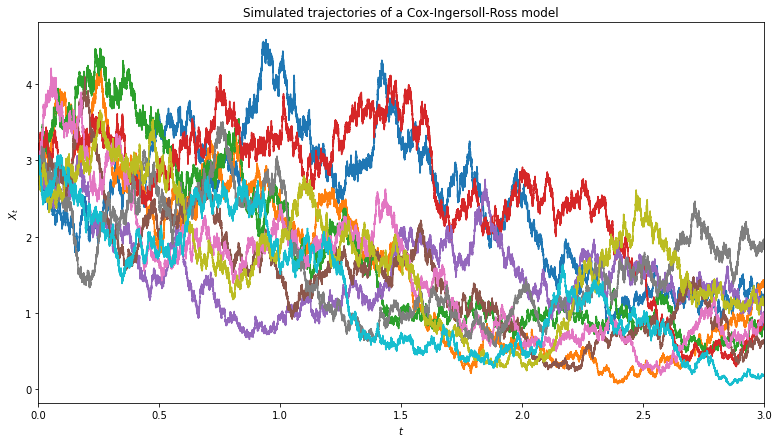

In [27]:
plot_trajectories(3, 100000, 10, 
                  "$X_t$", 
                  "Cox-Ingersoll-Ross model",
                  sim_func=CIR_SDE)

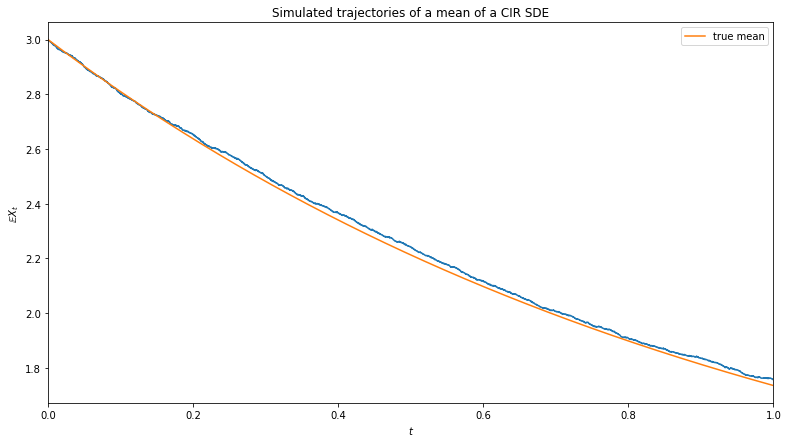

In [28]:
np.random.seed(10)

plot_trajectories(1, 10000, 1, "$\mathbb{E}X_t$", "mean of a CIR SDE", 
                  sim_func=estimate_mean, 
                  mean_func=lambda x: 1 + 2 * np.exp(-x),
                  process=CIR_SDE, num_iter=2000)

Notice that both Vasicek and CIR are mean-reverting

### 2.4 Heston’s Stochastic Volatility Model

\begin{eqnarray}
dX_t = rX_t dt + \sqrt{V_t} X_t d W_t^{(1)} \\
dV_t = \kappa (\theta - V_t)dt + \sigma \sqrt{V_t} d W_t^{(2)} \\
d W_t^{(1)}d W_t^{(2)} = \rho dt
\end{eqnarray}

In [29]:
def Hestons_SDE(length: float, num_splits: int,
                r: int = 0.5, kappa: int = 1.2, theta: int = 0.3, 
                sigma: int = 0.3, rho: int = -0.5,
                x_0: int = 100, v_0: int = 0.5) -> np.ndarray:
    
    delta = length / num_splits
    
    W1_traj = create_path_BM(length, num_splits)
    W2_traj = create_path_BM(length, num_splits)
    
    correlated_traj = np.c_[W1_traj, W2_traj] @ sqrtm(np.array([[1, rho], [rho, 1]]))
    W1_traj, W2_traj = correlated_traj[:, 0], correlated_traj[:, 1]
    
    X_t = np.zeros(num_splits + 1)
    V_t = np.zeros(num_splits + 1)
    
    X_t[0] = x_0
    V_t[0] = v_0
    
    for i in range(1, num_splits+1):
        X_t[i] = X_t[i-1] + r * X_t[i-1] * delta + np.sqrt(V_t[i-1]) * X_t[i-1] * (W1_traj[i] - W1_traj[i-1])
        V_t[i] = V_t[i-1] + kappa * (theta - V_t[i-1]) * delta + sigma * V_t[i-1] ** 0.5 * (W2_traj[i] - W2_traj[i-1])
    return X_t

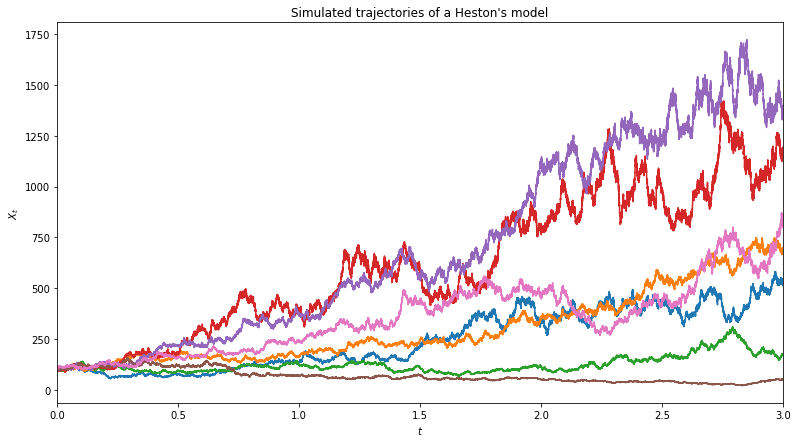

In [30]:
plot_trajectories(3, 100000, 7, 
                  "$X_t$", 
                  "Heston's model",
                  sim_func=Hestons_SDE)

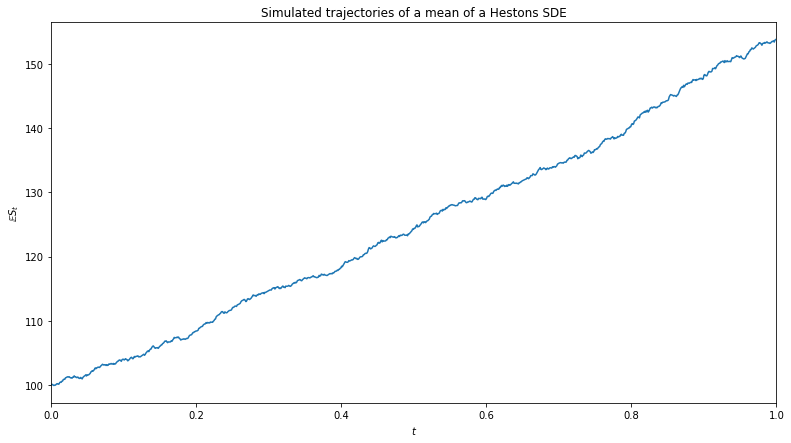

In [31]:
np.random.seed(12)

# no closed form i guess
plot_trajectories(1, 1000, 1, "$\mathbb{E}S_t$", "mean of a Hestons SDE", 
                  sim_func=estimate_mean, 
                  process=Hestons_SDE, num_iter=500)

## 3. Levy processes

A Levy process is a process $X_t$ which:

0) $\mathbb{P}\{X_0 = 0\}=1$

1) $X_t$ has independent increments

2) $X_t$ has stationary increments

3) $X_t$ is stochastically continuous

4) All trajectories are right-continuous with left limits 

Important definition related to Levy processes:
$$
\nu(B) = \mathbb{E}[\#\{t \in [0, 1]: \Delta X_t \in B\}]
$$
Function $\nu$ is a Levy measure -- it characterizes the jumps of the process (how often they occur and how large are the jumps).

### 3.1 Poisson process

Poisson proccess is a Levy process with increments distributed according to Poisson distribution:
$$
X_t - X_s \sim Pois(\lambda(t-s))
$$

In [36]:
def create_path_Poisson(length: float, num_splits: int,
                        lam: int = 1) -> np.ndarray:
    delta = num_splits / length
    increments = np.random.poisson(lam=lam/delta,
                                   size=num_splits)
    
    poisson_traj = np.zeros(num_splits+1)
    poisson_traj[1:] = np.cumsum(increments)
    return poisson_traj

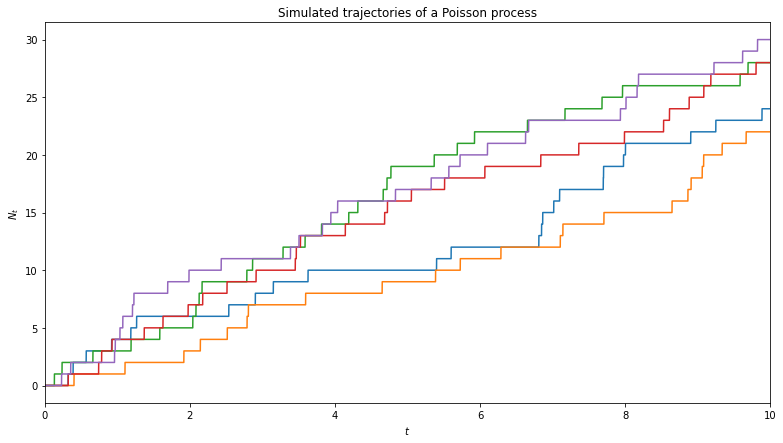

In [37]:
plot_trajectories(10, 100000, 5, 
                  "$N_t$", 
                  "Poisson process",
                  sim_func=create_path_Poisson,
                  lam=3)

### 3.2 Inhomogenous Poisson process

Poisson proccess is a Levy process with increments distributed according to Poisson distribution, but the distribution of the increments is not identical (generaly speaking):
$$
X_t - X_s \sim Pois(\Lambda(t)-\Lambda(s)))
$$

In [67]:
def create_path_InPoisson(length: float, num_splits: int,
                        lam: Callable) -> np.ndarray:
    delta = length / (num_splits + 1)
    time = np.arange(stop=length, step=delta)
    poisson_traj = np.zeros(num_splits+1)
    
    for i in range(1, num_splits+1):
        poisson_traj[i] = poisson_traj[i-1] + np.random.poisson(lam(time[i]) - lam(time[i-1]))
    return poisson_traj

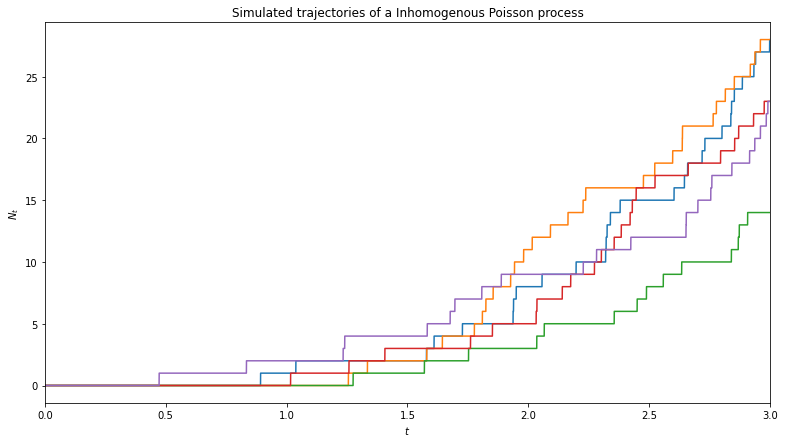

In [72]:
plot_trajectories(3, 100000, 5, 
                  "$N_t$", 
                  "Inhomogenous Poisson process",
                  sim_func=create_path_InPoisson,
                  lam=lambda x: x ** 3)

Jumps occur more often as time grows

### 3.3 Gamma process

Same old Levy proccess but the increments are distributed according to gamma distribution

In [32]:
def create_path_Gamma(length: float, num_splits: int,
                      a: int = 1, 
                      b: int = 1) -> np.ndarray:
    delta = num_splits / length
    increments = np.random.gamma(shape=a / delta ,
                                 scale=b,
                                 size=num_splits)
    
    gamma_traj = np.zeros(num_splits+1)
    gamma_traj[1:] = np.cumsum(increments)
    return gamma_traj

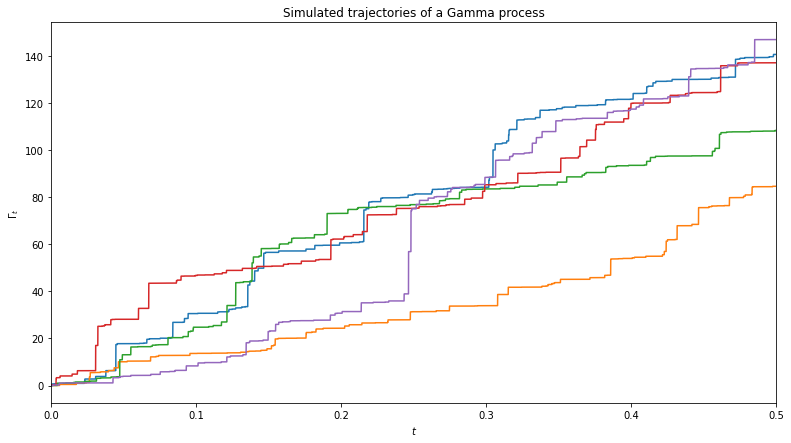

In [33]:
plot_trajectories(0.5, 100000, 5, 
                  "$\Gamma_t$", 
                  "Gamma process",
                  sim_func=create_path_Gamma,
                  a=50, b=5)

### 3.4 Variance gamma process

Variance Gamma process is the following Levy process (with the change of time trick):
$$
V\Gamma_t = \theta \Gamma_t + \sigma W_{\Gamma_t}
$$
In fact this is a Brownian motion with drift process, where the time was changed my Gamma process. Non-negative Levy processes (like Gamma) are called subordinators and they can be use to change the time in other processes.

In [34]:
def create_path_VGamma(length: float, num_splits: int,
                      a: int = 1, 
                      b: int = 1,
                      sigma: int = 1,
                      theta: int = 1) -> np.ndarray:
    delta = num_splits / length
    gamma_part = np.random.gamma(shape=a / delta ,
                                 scale=b,
                                 size=num_splits)
    gaussian_part = np.random.normal(size=num_splits)
    
    var_gamma_traj = np.zeros(num_splits+1)
    for i in range(1, num_splits+1):
        var_gamma_traj[i] = var_gamma_traj[i-1] + theta * gamma_part[i-1] 
        var_gamma_traj[i] += sigma * np.sqrt(gamma_part[i-1]) * gaussian_part[i-1]
        
    return var_gamma_traj

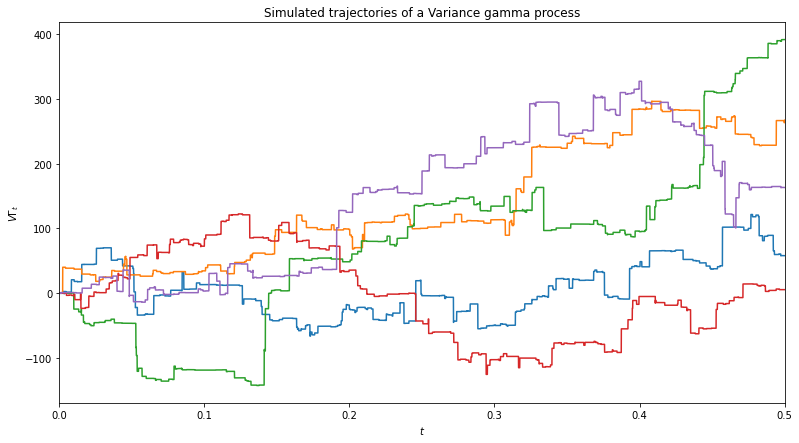

In [35]:
plot_trajectories(0.5, 100000, 5, 
                  "$V\Gamma_t$", 
                  "Variance gamma process",
                  sim_func=create_path_VGamma,
                  a=50, b=10, sigma=10)

### 3.5 Cauchy process

Cauchy proccess is a Levy process with increments distributed according to Cauchy distribution. It has no moments. You can see that extreme jumps occur quite a lot.

In [80]:
def create_path_Cauchy(length: float, num_splits: int,
                      a: int = 1, 
                      b: int = 1) -> np.ndarray:
    delta = num_splits / length
    increments = a / delta * np.random.standard_cauchy(size=num_splits)
    
    gamma_traj = np.zeros(num_splits+1)
    gamma_traj[1:] = np.cumsum(increments)
    return gamma_traj

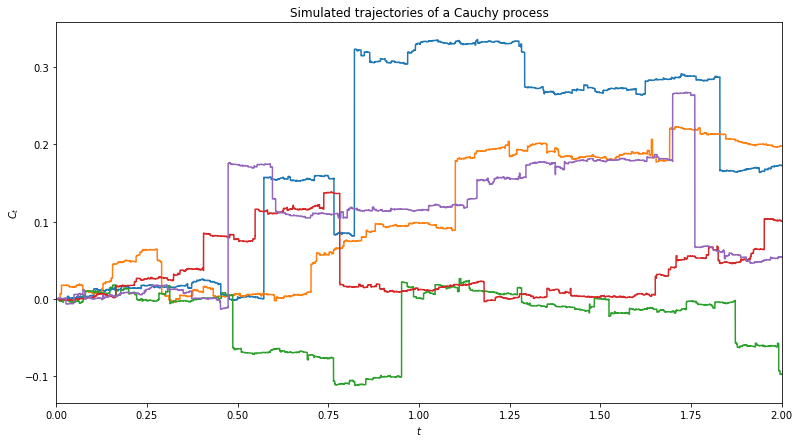

In [96]:
plot_trajectories(2, 100000, 5, 
                  "$С_t$", 
                  "Сauchy process",
                  sim_func=create_path_Cauchy,
                  a=0.1
                 )

In [ ]:
#### TODO:
## More theory
## More intuition with the financial models
## More advanced simulation methods
## Unify the way argument's names etc